In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datetime import datetime
from torchvision import datasets, transforms

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # 디바이 설정 
print("now device >> " , DEVICE)

now device >>  cpu


# parameters

In [4]:
RANDOM_SEED = 777
lr = 0.001
Batch_size = 32
number_epochs = 20

IMG_SIZE = 32
class_number = 10 # MNIST 데이터셋 => 0 ~ 9 -> 10개 클래스를 가지고 있음

## transforms 정의

In [5]:
trasnform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

## 데이터 다운로드, data loader

In [6]:
train_dataset = datasets.MNIST(root = "./mist_data",
                              train=True,
                              transform = trasnform,
                              download = True)

valid_dataset = datasets.MNIST(root = "./mist_data",
                              train=False,
                              transform = trasnform,
                              download = True)

train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Batch_size, shuffle=False)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 23772491.99it/s]


Extracting ./mist_data\MNIST\raw\train-images-idx3-ubyte.gz to ./mist_data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1844668.54it/s]


Extracting ./mist_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./mist_data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 8274745.23it/s]


Extracting ./mist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mist_data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./mist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mist_data\MNIST\raw



## 불러온 데이터 확인

C:\Users\ljh29\AppData\Local\Temp\ipykernel_11676\3672937961.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


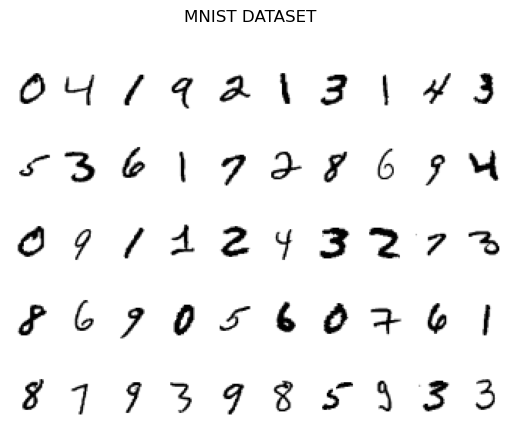

In [7]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1) : 
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle("MNIST DATASET")
fig.show()

## LeNet5 모델 정의

In [8]:
class LeNet5(nn.Module) : 
    def __init__(self, n_classes) : 
        super(LeNet5, self).__init__()
        
        """
        LeNet5 네트워크의 피처 추출 부분 
        """
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), 
            ### (32, 6, 높이, 너비)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), ## (32, 6, 높이/2, 너비/2) =>>> Feature map 크기가 절반이 됩니다. 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            ## (32, 6, 높이/2, 너비/2) =>>> ## (32, 16, 높이/2, 너비/2) =>>>)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            ##  (32, 16, 높이/2, 너비/2) ->  (32, 16, 높이/4, 너비/4) =>>> Feature map 크기가 절반이 됩니다. 
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            ## (32, 120, 높이/4, 너비/4) -> 최종 피처맵 크기 
            nn.Tanh(),
        )
        
        """
        LeNet5 모델의 분류기 부분 
        LeNet5 네트워크의 피처 추출 부분 -> out_channels=120 -> in_features=120 -> 84 (특성 차원 축소) -> 클래스 개수에대한 
        로짓을 출력합니다 -> 소프트맥스 함수 -> 클래스별 확률로 변환 
        """
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=class_number)
        )
    
    def forward(self, x) :
        x = self.feature_extractor(x) #### 입력 이미지 -> 특성 추출 과정 
        x = torch.flatten(x,1)      ##### classifier() -> 1차원으로 펼쳐주는 과정 !!
        logits = self.classifier(x) ##### 클래스별 로짓값 
        probs = F.softmax(logits, dim=1) #### 클래스별 확률 값 
        
        return logits, probs

### acc 구하는 함수 구현

In [9]:
def get_acc(model, data_loader, device) : 
    """
    전체 data_loader에 대한 에측 정확도를 계산하는 함수 !
    """
    correct_pred = 0
    n = 0 
    
    model.eval()
    
    with torch.no_grad() :
        for x, y_true in data_loader :
            x = x.to(device)
            y = y_true.to(device)
            
            _, y_prob = model(x)
            _, predicted_labels = torch.max(y_prob, 1)
            
            n += y.size(0)
            correct_pred += (predicted_labels == y).sum()
            
    return correct_pred.float() / n

In [10]:
def train(train_loader, model, criterion, optimizer, device) : 
    """
    training loop의 train 단계에 대한 함수 
    """
    model.train()  ## 모델을 학습모드로 설정 
    runing_loss = 0 ### runing_loss 0으로 초기화 
    
    for x, y in train_loader : 
        x = x.to(device) ### cuda / cpu
        y = y.to(device)
        
        optimizer.zero_grad()
        
        # 순전파 
        y_hat, _ = model(x)   ####### y_hat, _ ----> 예측, 확률값(probs) 
        loss = criterion(y_hat, y)
        runing_loss += loss.item() * x.size(0) ### 배치사이즈 만큼 처리를 위한 임시 변수 
        
        # 역전파 
        loss.backward()
        optimizer.step()
        
    epoch_loss = runing_loss / len(train_loader.dataset) # 평균 손실계산 
    
    return model, optimizer, epoch_loss

In [11]:
def validata(valid_loader, model, criterion, device) : 
    """
    training loop의 validation 단계에 대한 함수 
    """
    model.eval()
    runing_loss = 0 ### runing_loss 0으로 초기화
    
    for x, y_true in valid_loader : 
        x = x.to(device)
        y = y_true.to(device)
        
        # 순전파와 손실 기록 
        y_hat, _ = model(x)
        loss = criterion(y_hat, y)
        runing_loss += loss.item() * x.size(0)
        
    epoch_loss = runing_loss / len(valid_loader.dataset)
    
    return model, epoch_loss

## 학습 loop

In [12]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, pring_every=1) : 
    
    train_losses = []
    valid_losses = []
    
    # model 학습 
    for epoch in range(0, epochs) : 
        
        # train 
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # validation 
        with torch.no_grad() : 
            model, valid_loss = validata(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            
        if epoch % pring_every == (pring_every - 1) : 
            train_acc = get_acc(model, train_loader, device=device)
            valid_acc = get_acc(model, valid_loader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} ----------'
                  f'Epoch : {epoch + 1}\t'
                  f'Train loss : {train_loss:.4f}\t'
                  f'Valid loss : {valid_loss:.4f}\t'
                  f'Train ACC : {100 * train_acc:.2f}\t'
                  f'Valid ACC : {100 * valid_acc:.2f}')
            
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(class_number).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, class_number, DEVICE)

14:18:11 ----------Epoch : 1	Train loss : 0.2174	Valid loss : 0.0820	Train ACC : 97.56	Valid ACC : 97.54
14:27:06 ----------Epoch : 2	Train loss : 0.0768	Valid loss : 0.0546	Train ACC : 98.56	Valid ACC : 98.22
14:36:27 ----------Epoch : 3	Train loss : 0.0540	Valid loss : 0.0575	Train ACC : 98.51	Valid ACC : 98.14
